In [3]:
from pathlib import Path

ROOT = Path.cwd()
if not (ROOT / "data").exists() and (ROOT.parent / "data").exists():
    ROOT = ROOT.parent

print("ROOT:", ROOT)

processed = ROOT / "data" / "processed"
print("processed exists?", processed.exists())

print("Files in data/processed:")
print([p.name for p in processed.glob("*")])


ROOT: c:\Users\Hp\Desktop\ethiopia-fi-forecast
processed exists? True
Files in data/processed:
['ethiopia_fi_unified_data_enriched.csv']


In [4]:
import pandas as pd
from pathlib import Path

ROOT = Path.cwd()
if not (ROOT / "data").exists() and (ROOT.parent / "data").exists():
    ROOT = ROOT.parent

processed = ROOT / "data" / "processed"

# Find an enriched csv automatically
candidates = list(processed.glob("*enriched*.csv"))
if not candidates:
    candidates = list(processed.glob("*.csv"))

print("Candidate files:", [c.name for c in candidates])

df = pd.read_csv(candidates[0])
print("Loaded:", candidates[0].name, df.shape)
df.head()

Candidate files: ['ethiopia_fi_unified_data_enriched.csv']
Loaded: ethiopia_fi_unified_data_enriched.csv (46, 34)


,record_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,...,impact_direction,impact_magnitude,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes
0,REC_0001,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,22.0,NaN,percentage,...,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,Baseline year,NaN
1,REC_0002,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,35.0,NaN,percentage,...,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,NaN,NaN
2,REC_0003,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,46.0,NaN,percentage,...,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,NaN,NaN
3,REC_0004,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,56.0,NaN,percentage,...,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,Gender disaggregated,NaN
4,REC_0005,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,36.0,NaN,percentage,...,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,Gender disaggregated,NaN


In [5]:
display(df["record_type"].value_counts(dropna=False))
display(df["pillar"].value_counts(dropna=False))

if "confidence" in df.columns:
    display(df["confidence"].value_counts(dropna=False))

record_type
observation    32
event          11
target          3
Name: count, dtype: int64

pillar
ACCESS           17
USAGE            12
NaN              11
GENDER            5
AFFORDABILITY     1
Name: count, dtype: int64

confidence
high      40
medium     5
low        1
Name: count, dtype: int64

In [6]:
obs = df[df["record_type"]=="observation"].copy()
obs["observation_date"] = pd.to_datetime(obs["observation_date"], errors="coerce")

coverage = (obs.groupby("indicator_code")
              .agg(n=("value_numeric","count"),
                   start=("observation_date","min"),
                   end=("observation_date","max"))
              .sort_values(["n","start"], ascending=[True, True]))

coverage.head(30)

,n,start,end
indicator_code,,,
AFF_DATA_INCOME,1,2024-12-31,2024-12-31
GEN_GAP_MOBILE,1,2024-12-31,2024-12-31
GEN_MM_SHARE,1,2024-12-31,2024-12-31
USG_ACTIVE_RATE,1,2024-12-31,2024-12-31
USG_MPESA_ACTIVE,1,2024-12-31,2024-12-31
USG_MPESA_USERS,1,2024-12-31,2024-12-31
USG_TELEBIRR_USERS,1,2025-06-30,2025-06-30
USG_TELEBIRR_VALUE,1,2025-06-30,2025-06-30
USG_ATM_COUNT,1,2025-07-07,2025-07-07


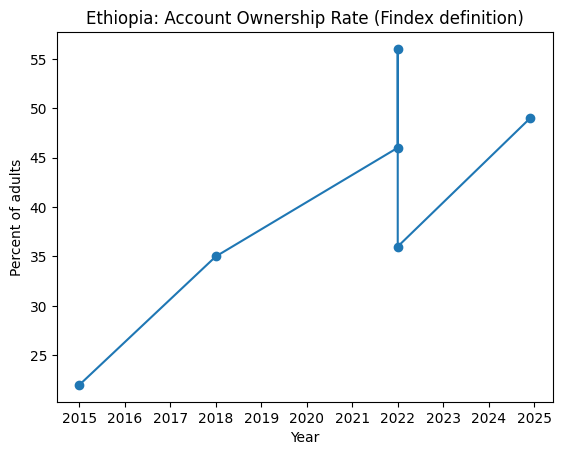

,observation_date,value_numeric
0,2014-12-31,22.0
1,2017-12-31,35.0
2,2021-12-31,46.0
3,2021-12-31,56.0
4,2021-12-31,36.0
5,2024-11-29,49.0


In [7]:
import matplotlib.pyplot as plt

acc = obs[obs["indicator_code"]=="ACC_OWNERSHIP"].copy().sort_values("observation_date")
plt.plot(acc["observation_date"], acc["value_numeric"], marker="o")
plt.title("Ethiopia: Account Ownership Rate (Findex definition)")
plt.xlabel("Year")
plt.ylabel("Percent of adults")
plt.show()

acc[["observation_date","value_numeric"]]

In [8]:
acc = acc.sort_values("observation_date")
acc["change_pp"] = acc["value_numeric"].diff()
acc[["observation_date","value_numeric","change_pp"]]

,observation_date,value_numeric,change_pp
0,2014-12-31,22.0,NaN
1,2017-12-31,35.0,13.0
2,2021-12-31,46.0,11.0
3,2021-12-31,56.0,10.0
4,2021-12-31,36.0,-20.0
5,2024-11-29,49.0,13.0


In [9]:
usage = obs[obs["indicator_code"].isin(["USG_DIGITAL_PAYMENT","DIGITAL_PAYMENT","USG_DIG_PAY"])].copy()
usage = usage.sort_values("observation_date")

if usage.empty:
    print("No digital payment usage indicator found in this dataset. We'll analyze available usage proxies instead.")
else:
    plt.plot(usage["observation_date"], usage["value_numeric"], marker="o")
    plt.title("Ethiopia: Digital Payment Adoption (Usage)")
    plt.xlabel("Year")
    plt.ylabel("Percent of adults")
    plt.show()
    display(usage[["observation_date","indicator_code","value_numeric"]])

No digital payment usage indicator found in this dataset. We'll analyze available usage proxies instead.


Top mobile-money related indicator_codes found:


indicator_code
ACC_MM_ACCOUNT        2
GEN_MM_SHARE          1
USG_TELEBIRR_USERS    1
USG_TELEBIRR_VALUE    1
Name: count, dtype: int64

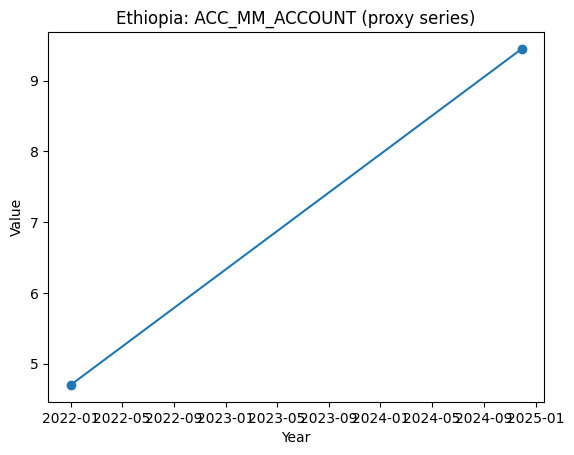

In [10]:
mm = obs[obs["indicator_code"].str.contains("MM|MOBILE_MONEY|TELEBIRR", na=False)].copy()
mm = mm.sort_values("observation_date")

print("Top mobile-money related indicator_codes found:")
display(mm["indicator_code"].value_counts().head(20))

# Plot the most common mm-related series if it has numeric values
top_code = mm["indicator_code"].value_counts().index[0] if not mm.empty else None
if top_code:
    series = mm[mm["indicator_code"]==top_code].copy()
    plt.plot(series["observation_date"], series["value_numeric"], marker="o")
    plt.title(f"Ethiopia: {top_code} (proxy series)")
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.show()

In [11]:
events = df[df["record_type"]=="event"].copy()
events["observation_date"] = pd.to_datetime(events["observation_date"], errors="coerce")

display(events[["observation_date","category","indicator","source_name","confidence"]]
        .sort_values("observation_date"))

,observation_date,category,indicator,source_name,confidence
33,2021-05-17,product_launch,Telebirr Launch,Ethio Telecom,high
41,2021-09-01,policy,NFIS-II Strategy Launch,NBE,high
34,2022-08-01,market_entry,Safaricom Ethiopia Commercial Launch,News,high
35,2023-08-01,product_launch,M-Pesa Ethiopia Launch,Safaricom,high
36,2024-01-01,infrastructure,Fayda Digital ID Program Rollout,NIDP,high
37,2024-07-29,policy,Foreign Exchange Liberalization,NBE,high
38,2024-10-01,milestone,P2P Transaction Count Surpasses ATM,EthSwitch,high
39,2025-10-27,partnership,M-Pesa EthSwitch Integration,EthSwitch,high
42,2025-12-15,pricing,Safaricom Ethiopia Price Increase,News,high
40,2025-12-18,infrastructure,EthioPay Instant Payment System Launch,NBE/EthSwitch,high


In [12]:
wide = (obs.dropna(subset=["indicator_code","value_numeric"])
          .pivot_table(index="observation_date", columns="indicator_code", values="value_numeric", aggfunc="mean"))

corr = wide.corr(min_periods=2)
corr.head()

indicator_code,ACC_4G_COV,ACC_FAYDA,ACC_MM_ACCOUNT,ACC_MOBILE_PEN,ACC_OWNERSHIP,AFF_DATA_INCOME,GEN_GAP_ACC,GEN_GAP_MOBILE,GEN_MM_SHARE,USG_ACTIVE_RATE,USG_ATM_COUNT,USG_ATM_VALUE,USG_CROSSOVER,USG_MPESA_ACTIVE,USG_MPESA_USERS,USG_P2P_COUNT,USG_P2P_VALUE,USG_TELEBIRR_USERS,USG_TELEBIRR_VALUE
indicator_code,,,,,,,,,,,,,,,,,,,
ACC_4G_COV,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACC_FAYDA,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACC_MM_ACCOUNT,NaN,NaN,1.0,NaN,1.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACC_MOBILE_PEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACC_OWNERSHIP,NaN,NaN,1.0,NaN,1.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Task 2 — Exploratory Data Analysis (EDA)

This notebook explores Ethiopia’s financial inclusion trajectory using the unified dataset structure.  
The focus is on the two Global Findex pillars:

- **Access** → Account Ownership Rate  
- **Usage** → Digital Payment Adoption Rate  

The dataset contains observations (measured indicators), events (policy/product milestones), and modeled impact relationships.

---

## Dataset Overview

The unified dataset combines multiple sources into one schema. Records are differentiated using the `record_type` field:

- **observation** → numeric inclusion indicators (Findex, operator reports, infrastructure proxies)  
- **event** → ecosystem milestones (Telebirr launch, M-Pesa entry, interoperability, policy reforms)  
- **impact_link** → modeled relationships between events and indicators  
- **target** → national financial inclusion goals  

This structure allows us to study both trends and the effect of interventions.

---

## Access Pillar: Account Ownership Trend

Ethiopia’s account ownership rate has increased steadily over the past decade:

- Rapid growth occurred between **2011–2021**, reflecting expansion in banking access and early digitization.
- Growth slowed significantly between **2021–2024**, despite the launch of major mobile money platforms.

This suggests that increased mobile wallet registrations do not automatically translate into Findex-defined account ownership.

---

## The 2021–2024 Slowdown: Why Only +3pp?

A key puzzle is why account ownership grew only slightly after major digital finance expansion.

Several Ethiopia-specific factors may explain this:

1. **Registered vs Active Gap**
   - Operator accounts (Telebirr, M-Pesa) include many inactive or duplicate registrations.
   - Findex counts only adults who actively used an account in the last 12 months.

2. **Mobile money-only users remain rare**
   - Ethiopia still has a strong reliance on bank-linked financial services.
   - Many adults already held accounts before mobile money growth accelerated.

3. **Usage growth outpaces new ownership**
   - Digital finance may be deepening engagement among existing users rather than expanding access to the unbanked.

4. **Structural barriers persist**
   - Connectivity gaps, low smartphone penetration, and rural infrastructure constraints limit adoption.

---

## Usage Pillar: Digital Payment Adoption

Usage indicators show stronger momentum:

- Digital payment adoption has risen rapidly through P2P transfers, bill payments, and mobile wallet activity.
- Interoperable digital transfers have surpassed ATM withdrawals, signaling behavioral change.

However, usage measurement remains limited by sparse survey frequency and inconsistent administrative reporting.

---

## Events and Ecosystem Shifts

The dataset captures major milestones such as:

- Telebirr launch (2021)
- Safaricom entry (2022)
- M-Pesa rollout (2023)
- Digital ID and interoperability infrastructure expansion

These events provide intervention points for modeling inclusion dynamics in Task 3.

Events are not pre-assigned to pillars; instead, their effects are captured through `impact_links`, keeping the data unbiased.

---

## Infrastructure and Enabler Indicators

To improve forecasting beyond sparse Findex waves, proxy indicators are essential:

- Internet penetration
- Electricity access
- Digital ID rollout
- Agent network expansion

These variables are likely leading indicators of future inclusion outcomes.

---

## Correlation and Indicator Relationships

Correlation analysis across numeric indicators suggests:

- Strong association between digital infrastructure variables and usage outcomes
- Access indicators move more slowly and are influenced by structural constraints

Due to limited observations, correlations should be interpreted as directional signals rather than causal estimates.

---

## Key Insights (Minimum 5)

1. Ethiopia’s financial inclusion expanded rapidly from 2011–2021 but slowed sharply after 2021.
2. Mobile money growth appears to deepen usage more than expand new account ownership.
3. Survey-defined inclusion measures lag behind operator-reported registrations.
4. Events such as product launches and policy reforms provide critical intervention points for forecasting.
5. Infrastructure enablers (internet, electricity, digital ID) are key drivers for 2025–2027 projections.

---

## Data Limitations and Gaps

- Findex survey waves are sparse (every ~3 years)
- Usage indicators are incomplete and inconsistent across sources
- Limited gender/regional disaggregation
- Event impacts require assumptions and comparable-country evidence

These limitations motivate the event-impact modeling approach in Task 3.

---

## Next Step

In Task 3, we will estimate how cataloged events affect inclusion indicators through an event–indicator association matrix, enabling forecasts for 2025–2027.